In [ ]:
import numpy as np
from scipy.linalg import eig

# Constants
g = 9.81  # acceleration due to gravity (m/s^2)
l = 1.0   # rod length (m)

# Mass and stiffness matrices for angular coordinates
Me = np.array([[l, 0],
               [0, 0]])

Ke = np.array([[g, 0],
               [0, 0]])

# Mass and stiffness matrices for Cartesian coordinates
Mq = np.array([[l, 0],
               [0, l]])

Kq = np.array([[g, 0],
               [0, g]])

# Eigenvalue computation for angular coordinates
eigenvalues_angular, _ = eig(Ke, b=Me)

# Eigenvalue computation for Cartesian coordinates
eigenvalues_cartesian, _ = eig(Kq, b=Mq)

print("Eigenvalues for angular coordinates:", eigenvalues_angular)
print("Eigenvalues for Cartesian coordinates:", eigenvalues_cartesian)

Eigenvalues for angular coordinates: [9.81+0.j  nan+0.j]
Eigenvalues for Cartesian coordinates: [9.81+0.j 9.81+0.j]


In [ ]:
import numpy as np
from scipy.linalg import eig

# Constants
g = 9.81  # acceleration due to gravity (m/s^2)
l = 1.0   # rod length (m)

# Mass and stiffness matrices for angular coordinates
Me = np.array([[l, 0],
               [0, 0]])

Ke = np.array([[g, 0],
               [0, 0]])

# Mass and stiffness matrices for Cartesian coordinates
Mq = np.array([[l, 0],
               [0, l]])

Kq = np.array([[g, 0],
               [0, g]])

# Eigenvalue computation for angular coordinates
eigenvalues_angular, _ = eig(Ke, b=Me)

# Eigenvalue computation for Cartesian coordinates
eigenvalues_cartesian, _ = eig(Kq, b=Mq)

print("Eigenvalues for angular coordinates:", eigenvalues_angular)
print("Eigenvalues for Cartesian coordinates:", eigenvalues_cartesian)


Eigenvalues for angular coordinates: [9.81+0.j  nan+0.j]
Eigenvalues for Cartesian coordinates: [9.81+0.j 9.81+0.j]


In [ ]:
!pip install torch
!pip install numpy



Avg. relative squared error:  2.2804672434069176e-10

Calculation time:  233.07183623313904


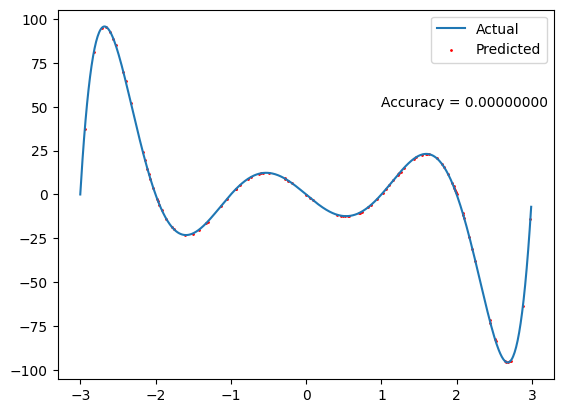

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import multiprocessing as mp
import time

def sim_pend(xyz,t,w,l,F):
    x = xyz[0]
    y = xyz[1]

    dx = np.zeros(2)
    g = 10.0
    k = 0.05

    dx[0] = y
    dx[1] = - k*y - (g/l)*np.sin(x) + F*np.sign(np.sin(w*t))

    return dx


def poly(x):
    y = (x-3)*(x-2)*(x-1)*x*(x+1)*(x+2)*(x+3)
    return y



def integ(N,kt,l,w,F):
    om = w    # Data sampling cycle frequency
    tau = 2*np.pi/(om*kt) # Sampling interval

    t = np.arange(0,N*kt*tau,tau) # time points
    x0 = np.array([0,0])
    x = odeint(sim_pend,x0,t,args=(l,w,F,))

    eps = 0  # Noise strength
    noise = eps*(2*np.random.random(len(t))-1)

    return x[:,0]+noise




if __name__ == '__main__':

    start_time = time.time()

    tr_len = 500       # training length
    test_len = 100     # testing length

    ran = tr_len + test_len

    x_sr = np.linspace(-3,3,ran)
    np.random.shuffle(x_sr)
    y_sr = poly(x_sr)

    u = (x_sr+3)/6  #scaling the input in range [0:1]

    N = 10      #number of smapling cycle
    kt = 20     #number of sampled data per cycle

    F = 1 + u       #forcing amplitude (input scaled in range [1:2])
    w = 1.0         #forcing frequency
    l = 1.0         #length of the pendulum


    avg = 10    #Number of runs to be averaged upon
    err_st = []
    for i in range(avg):
        print('Averaging Calculation progress; %d out of %d.'%(i+1,avg),end='\r')
        #Generating reservoir states
        pool = mp.Pool(mp.cpu_count()-1)
        out = pool.starmap(integ,[(N,kt,l,w,f) for f in F])
        pool.close()
        pool.join()

        x_st = np.array(out)

        xs_tr = x_st[:tr_len,:]     #Reservoir states corresponding to training input
        xs_test = x_st[tr_len:,:]   #Reservoir states corresponding to test input

        y_tr = y_sr[:tr_len]        # Training labels
        x_test = x_sr[tr_len:]      # Test input
        y_test = y_sr[tr_len:]      # Target output

        w_ij = np.dot(np.linalg.pinv(xs_tr),y_tr)   # Regression
        f_out = np.dot(xs_test,w_ij)                # Prediction

        err = sum((y_test - f_out)**2)/sum((y_test)**2)

        err_st.append(err)

    print('\nAvg. relative squared error: ',sum(err_st)/avg)


    req_time = time.time() - start_time
    print('\nCalculation time: ',req_time)




    # plotting the result for last averaging iteration
    plt.plot(np.arange(-3,3,0.01),poly(np.arange(-3,3,0.01)),label = 'Actual')
    plt.scatter(x_test,f_out,s=1.0,label = 'Predicted',c='red')
    plt.text(1,50,'Accuracy = %1.8f'%err)
    plt.legend()
    plt.show()



Avg. relative squared error:  9.36532315216071e-07

Calculation time:  87.14137029647827


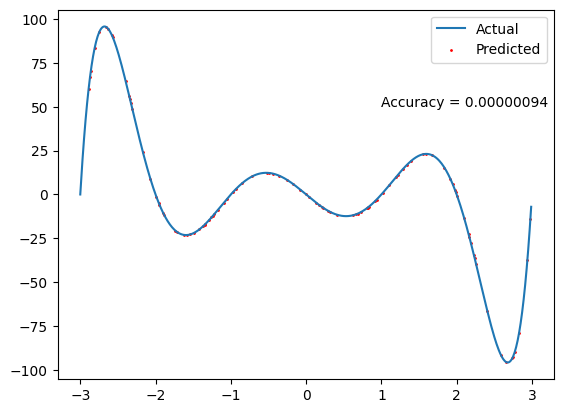

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import multiprocessing as mp
import time

def sim_pend(xyz,t,w,l,F):
    x = xyz[0]
    y = xyz[1]

    dx = np.zeros(2)
    g = 10.0
    k = 0.05

    dx[0] = y
    dx[1] = - k*y - (g/l)*np.sin(x) + F*np.sign(np.sin(w*t))

    return dx


def poly(x):
    y = (x-3)*(x-2)*(x-1)*x*(x+1)*(x+2)*(x+3)
    return y



def integ(N,kt,l,w,F):
    om = (10/l)**0.5    # Data sampling cycle frequency
    tau = 2*np.pi/(om*kt) # Sampling interval

    t = np.arange(0,N*kt*tau,tau) # time points
    x0 = np.array([0,0])
    x = odeint(sim_pend,x0,t,args=(l,w,F,))

    eps = 0  # Noise strength
    noise = eps*(2*np.random.random(len(t))-1)

    return x[:,0]+noise



if __name__ == '__main__':

    start_time = time.time()

    tr_len = 500       # training length
    test_len = 100     # testing length

    ran = tr_len + test_len

    x_sr = np.linspace(-3,3,ran)
    np.random.shuffle(x_sr)
    y_sr = poly(x_sr)

    u = (x_sr+3)/6  #scaling the input in range [0:1]

    N = 10      #number of smapling cycle
    kt = 20     #number of sampled data per cycle

    f = 1.5         #forcing amplitude
    W = 0.5 + 0.5*u #forcing frequency (input scaled in range [0.5:1])
    l = 1.0         #length of the pendulum


    avg = 10    #Number of runs to be averaged upon
    err_st = []
    for i in range(avg):
        print('Averaging calculation progress; %d out of %d runs.'%(i+1,avg),end='\r')
        #Generating reservoir states
        pool = mp.Pool(mp.cpu_count()-1)
        out = pool.starmap(integ,[(N,kt,l,w,f) for w in W])
        pool.close()
        pool.join()

        x_st = np.array(out)

        xs_tr = x_st[:tr_len,:]     #Reservoir states corresponding to training input
        xs_test = x_st[tr_len:,:]   #Reservoir states corresponding to test input

        y_tr = y_sr[:tr_len]        # Training labels
        x_test = x_sr[tr_len:]      # Test input
        y_test = y_sr[tr_len:]      # Target output

        w_ij = np.dot(np.linalg.pinv(xs_tr),y_tr)   # Regression
        f_out = np.dot(xs_test,w_ij)                # Prediction

        err = sum((y_test - f_out)**2)/sum((y_test)**1)

        err_st.append(err)

    print('\nAvg. relative squared error: ',sum(err_st)/avg)


    req_time = time.time() - start_time
    print('\nCalculation time: ',req_time)


    # plotting the result for last averaging iteration
    plt.plot(np.arange(-3,3,0.01),poly(np.arange(-3,3,0.01)),label = 'Actual')
    plt.scatter(x_test,f_out,s=1.0,label = 'Predicted',c='red')
    plt.text(1,50,'Accuracy = %1.8f'%err)
    plt.legend()
    plt.show()


Generating reservoir states, please wait...
 It may take few minutes.

 Relative squared error:  9.106208051679483e-05

Calculation time:  407.96837282180786


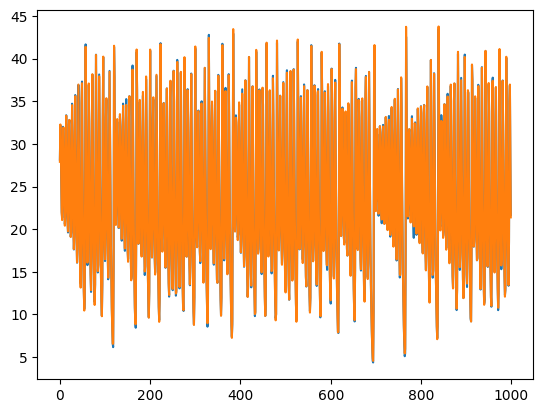

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import multiprocessing as mp
import time


def lorenz(arr,t):
    x = arr[0]
    y = arr[1]
    z = arr[2]

    dx = np.zeros(3)

    rho = 28.0

    dx[0] = 10*(y - x)
    dx[1] = -x*z + rho*x - y
    dx[2] = x*y - (8/3)*z
    return dx


def sim_pend(xyz,t,l,w,F):
    x = xyz[0]
    y = xyz[1]

    dx = np.zeros(2)
    g = 10
    k = 0.05

    dx[0] = y
    dx[1] = - k*y - (g/l)*np.sin(x) + F*np.sign(np.sin(w*t))

    return dx



def integ(N,kt,l,w,F):
    om = w    # Data sampling cycle frequency
    tau = 2*np.pi/(om*kt) # Sampling interval

    t = np.arange(0,N*kt*tau,tau) # time points
    x0 = np.array([0,0])
    x = odeint(sim_pend,x0,t,args=(l,w,F,))

    eps = 0  # Noise strength
    noise = eps*(2*np.random.random(len(t))-1)

    return x[:,0]+noise




if __name__ == '__main__':

    start_time = time.time()

    # Preparing Lorenz system data
    x0 = np.random.random(3)
    t = np.linspace(0,1200,12001)
    x = odeint(lorenz,x0,t)


    tr_len = 4100       # training length
    test_len = 1100     # testing length

    ran = tr_len + test_len

    tran = 1000
    u_sr = x[tran:tran+ran,0]    # x - state variable in input
    v_sr = x[tran:tran+ran,2]    # z - state variable in output

    mn = np.min(u_sr)
    mx = np.max(u_sr)
    u = (u_sr-mn)/(mx-mn)       #scaling the input in range [0:1]

    N = 10      #number of smapling cycle
    kt = 20     #number of sampled data per cycle

    F = 1 + u       #forcing amplitude (input scaled in range [1:2])
    w = 1.0         #forcing frequency
    l = 1.0         #length of the pendulum


    print('Generating reservoir states, please wait...\n It may take few minutes.')

    x0 = np.array([0,0])
    pool = mp.Pool(mp.cpu_count()-1)
    out = pool.starmap(integ,[(N,kt,l,w,f) for f in F])
    pool.close()
    pool.join()

    temp = np.array(out)
    x_st = np.copy(temp)


    #Creating reservoir states vectors for regression

    mem = 100       # memory (Number of previous reservoir dynamics to consider)
    wei = np.arange(1,0,-1/mem)
    for i in range(1,mem):
        x_st = np.hstack((wei[i]*np.roll(temp,i,axis=0),x_st))

    x_st = x_st[mem:,:]


    xs_tr = x_st[:tr_len,:]         #Reservoir states corresponding to training input
    xs_test = x_st[tr_len:,:]       #Reservoir states corresponding to test input

    y_tr = v_sr[mem:mem+tr_len]     # Training labels
    y_test = v_sr[mem+tr_len:]      # Target dynamics

    w_ij = np.dot(np.linalg.pinv(xs_tr),y_tr)   #Regression
    f_out = np.dot(xs_test,w_ij)                #Predicted dynamics

    err = sum((y_test - f_out)**2)/sum((y_test)**2)

    print('\n Relative squared error: ',err)

    req_time = time.time() - start_time
    print('\nCalculation time: ',req_time)


    plt.plot(f_out)
    plt.plot(y_test)
    plt.show()

Generating reservoir states, please wait...
 It may take few minutes.

 Relative squared error:  4.26570530683274e-05

Calculation time:  281.9899182319641


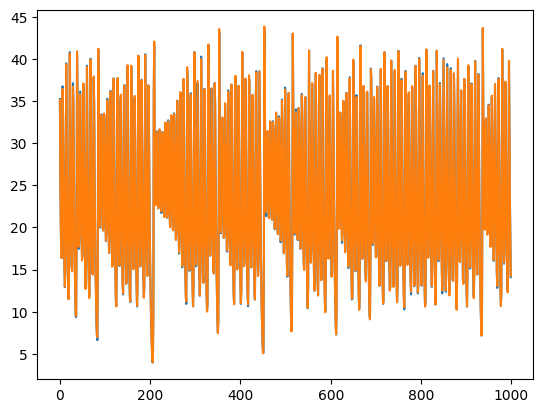

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import multiprocessing as mp
import time



def lorenz(arr,t):
    x = arr[0]
    y = arr[1]
    z = arr[2]

    dx = np.zeros(3)

    rho = 28.0

    dx[0] = 10*(y - x)
    dx[1] = -x*z + rho*x - y
    dx[2] = x*y - (8/3)*z
    return dx





def sim_pend(xyz,t,l,w,F):
    x = xyz[0]
    y = xyz[1]

    dx = np.zeros(2)
    g = 10.0
    k = 0.05

    dx[0] = y
    dx[1] = - k*y - (g/l)*np.sin(x) + F*np.sign(np.sin(w*t))

    return dx



def integ(N,kt,l,w,F):
    om = (10/l)**0.5    # Data sampling cycle frequency
    tau = 2*np.pi/(om*kt) # Sampling interval

    t = np.arange(0,N*kt*tau,tau) # time points
    x0 = np.array([0,0])
    x = odeint(sim_pend,x0,t,args=(l,w,F,))

    eps = 0  # Noise strength
    noise = eps*(2*np.random.random(len(t))-1)

    return x[:,0]+noise




if __name__ == '__main__':

    start_time = time.time()


    # Preparing Lorenz system data
    x0 = np.random.random(3)
    t = np.linspace(0,1200,12001)
    x = odeint(lorenz,x0,t)


    tr_len = 4100       # training length
    test_len = 1100     # testing length

    ran = tr_len + test_len

    tran = 1000
    u_sr = x[tran:tran+ran,0]    # x - state variable in input
    v_sr = x[tran:tran+ran,2]    # z - state variable in output

    mn = np.min(u_sr)
    mx = np.max(u_sr)
    u = (u_sr-mn)/(mx-mn)       #scaling the input in range [0:1]


    N = 10      #number of smapling cycle
    kt = 20     #number of sampled data per cycle

    f = 1.5             #forcing amplitude
    W = 0.5 + 0.5*u     #forcing frequency (input scaled in range [0.5:1])
    l = 1.0             #length of the pendulum


    print('Generating reservoir states, please wait...\n It may take few minutes.')

    x0 = np.array([0,0])

    pool = mp.Pool(mp.cpu_count()-1)
    out = pool.starmap(integ,[(N,kt,l,w,f) for w in W])
    pool.close()
    pool.join()

    temp = np.array(out)
    x_st = np.copy(temp)


    #Creating reservoir states vectors for regression

    mem = 100       # memory (Number of previous reservoir dynamics to consider)
    wei = np.arange(1,0,-1/mem)
    for i in range(1,mem):
        x_st = np.hstack((wei[i]*np.roll(temp,i,axis=0),x_st))

    x_st = x_st[mem:,:]


    xs_tr = x_st[:tr_len,:]         #Reservoir states corresponding to training input
    xs_test = x_st[tr_len:,:]       #Reservoir states corresponding to test input

    y_tr = v_sr[mem:mem+tr_len]     # Training labels
    y_test = v_sr[mem+tr_len:]      # Target dynamics

    w_ij = np.dot(np.linalg.pinv(xs_tr),y_tr)   #Regression
    f_out = np.dot(xs_test,w_ij)                #Predicted dynamics

    err = sum((y_test - f_out)**2)/sum((y_test)**2)

    print('\n Relative squared error: ',err)

    req_time = time.time() - start_time
    print('\nCalculation time: ',req_time)


    plt.plot(f_out)
    plt.plot(y_test)
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Function to simulate the dynamics of the 3D pendulum
def sim_pend(xyz, t, w, l, F):
    x, y = xyz
    dx = np.zeros(2)
    g = 10.0
    k = 0.05
    dx[0] = y
    dx[1] = -k * y - (g / l) * np.sin(x) + F * np.sign(np.sin(w * t))
    return dx

# Function to generate data for reservoir computing
def generate_reservoir_data(N, kt, l, w, F):
    om = w  # Data sampling cycle frequency
    tau = 2 * np.pi / (om * kt)  # Sampling interval
    t = np.arange(0, N * kt * tau, tau)  # time points
    x0 = np.array([0, 0])
    x = odeint(sim_pend, x0, t, args=(l, w, F,))
    eps = 0  # Noise strength
    noise = eps * (2 * np.random.random(len(t)) - 1)
    return x[:, 0] + noise

# Function to linearize the dynamics and calculate eigenvalues
def linearize_pendulum(x, y):
    # Assuming x and y are the coordinates of the point P
    M_e = np.array([[l, 0], [0, 0]])
    K_e = np.array([[g, 0], [0, 0]])
    Y_e = np.array([x, y])
    eigenvalues = np.linalg.eigvals(np.linalg.pinv(M_e) @ K_e)
    return eigenvalues

# Function to train and evaluate a reservoir computing model
def train_and_evaluate_reservoir(x_data, y_data, test_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, random_state=42)

    # Reservoir computing
    reservoir_model = make_pipeline(StandardScaler(), LinearRegression())
    reservoir_model.fit(x_train, y_train)
    y_pred = reservoir_model.predict(x_test)
    mse_reservoir = mean_squared_error(y_test, y_pred)

    return mse_reservoir

# Main function
if __name__ == '__main__':
    tr_len = 500  # training length
    test_len = 100  # testing length
    ran = tr_len + test_len
    x_sr = np.linspace(-3, 3, ran)
    np.random.shuffle(x_sr)
    y_sr = poly(x_sr)
    u = (x_sr + 3) / 6  # scaling the input in range [0:1]

    N = 10  # number of sampling cycles
    kt = 20  # number of sampled data per cycle

    F = 1 + u  # forcing amplitude (input scaled in range [1:2])
    w = 1.0  # forcing frequency
    l = 1.0  # length of the pendulum

    avg = 10  # Number of runs to be averaged upon
    err_st = []

    for i in range(avg):
        print('Averaging Calculation progress; %d out of %d.' % (i + 1, avg), end='\r')
        # Generating reservoir states
        x_st = np.array([generate_reservoir_data(N, kt, l, w, f) for f in F])
        x_st_linearized = np.array([linearize_pendulum(x[0], x[1]) for x in x_st])

        mse_reservoir = train_and_evaluate_reservoir(x_st, x_st_linearized)
        err_st.append(mse_reservoir)

    avg_mse_reservoir = sum(err_st) / avg
    print('\nAvg. Mean Squared Error (Reservoir):', avg_mse_reservoir)



Avg. Mean Squared Error (Reservoir): 5.679798517591285e-29


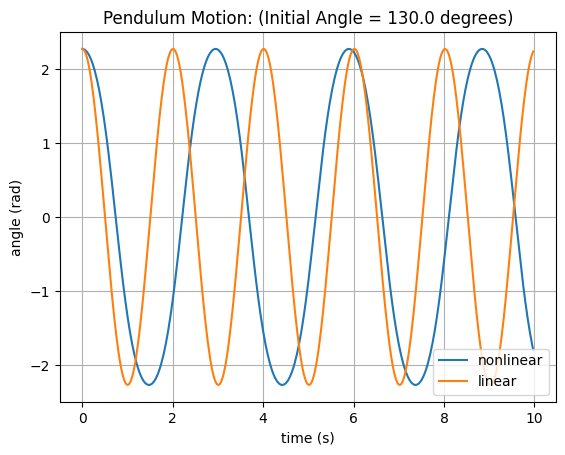

In [ ]:
import numpy as np
from numpy import sin, cos
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the equations
def equations(y0, t):
    theta, x = y0
    f = [x, -(g/l) * sin(theta)]
    return f

def plot_results(time, theta1, theta2):
    plt.plot(time, theta1[:, 0])
    plt.plot(time, theta2)

    s = '(Initial Angle = ' + str(initial_angle) + ' degrees)'
    plt.title('Pendulum Motion: ' + s)
    plt.xlabel('time (s)')
    plt.ylabel('angle (rad)')
    plt.grid(True)
    plt.legend(['nonlinear', 'linear'], loc='lower right')
    plt.show()

# Parameters
g = 9.81
l = 1.0

time = np.arange(0, 10.0, 0.025)

# Initial conditions
initial_angle = 130.0
theta0 = np.radians(initial_angle)
x0 = np.radians(0.0)

# Find the solution to the nonlinear problem
theta1 = odeint(equations, [theta0, x0], time)

# Find the solution to the linear problem
w = np.sqrt(g/l)
theta2 = theta0 * cos(w * time)  # Match the shape of theta1

# Plot the results
plot_results(time, theta1, theta2)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Rest of the code remains the same

# Function to train and evaluate a reservoir computing model
def train_and_evaluate_reservoir(x_data, y_data, test_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, random_state=42)

    # Reservoir computing
    reservoir_model = make_pipeline(StandardScaler(), LinearRegression())
    x_train_flat = x_train.reshape((x_train.shape[0], -1))
    x_test_flat = x_test.reshape((x_test.shape[0], -1))
    reservoir_model.fit(x_train_flat, y_train)
    y_pred = reservoir_model.predict(x_test_flat)
    mse_reservoir = mean_squared_error(y_test, y_pred)

    return mse_reservoir, y_test, y_pred

# Main function
if __name__ == '__main__':
    tr_len = 500  # training length
    test_len = 100  # testing length
    ran = tr_len + test_len
    x_sr = np.linspace(-3, 3, ran)
    np.random.shuffle(x_sr)
    y_sr = poly(x_sr)
    u = (x_sr + 3) / 6  # scaling the input in range [0:1]

    N = 10  # number of sampling cycles
    kt = 20  # number of sampled data per cycle

    F = 1 + u  # forcing amplitude (input scaled in range [1:2])
    w = 1.0  # forcing frequency
    l = 1.0  # length of the pendulum

    avg = 10  # Number of runs to be averaged upon
    err_st = []

    for i in range(avg):
        print('Averaging Calculation progress; %d out of %d.' % (i + 1, avg), end='\r')
        # Generating reservoir states
        x_st = np.array([generate_reservoir_data(N, kt, l, w, f) for f in F])
        x_st_linearized = np.array([linearize_pendulum(x[0], x[1]) for x in x_st])

        mse_reservoir, y_test, y_pred = train_and_evaluate_reservoir(x_st, x_st_linearized)
        err_st.append(mse_reservoir)

        # Print eigenvalues
        print('Eigenvalues:', linearize_pendulum(x_st[0, 0], x_st[0, 1]))

    avg_mse_reservoir = sum(err_st) / avg
    print('\nAvg. Mean Squared Error (Reservoir):', avg_mse_reservoir)


Eigenvalues: [9.81 0.  ]
Eigenvalues: [9.81 0.  ]
Eigenvalues: [9.81 0.  ]
Eigenvalues: [9.81 0.  ]
Eigenvalues: [9.81 0.  ]
Eigenvalues: [9.81 0.  ]
Eigenvalues: [9.81 0.  ]
Eigenvalues: [9.81 0.  ]
Eigenvalues: [9.81 0.  ]
Eigenvalues: [9.81 0.  ]

Avg. Mean Squared Error (Reservoir): 5.679798517591285e-29


In [ ]:
import numpy as np
from scipy.linalg import eigh

# System properties
g = 9.81  # Gravity (m/s^2)
l = 1.0   # Rod length (m)
m = 1.0   # Point mass (kg)

# Linearized dynamics matrices
M_e = np.array([[l, 0], [0, m]])
K_e = np.array([[g, 0], [0, 0]])

# Check positive definiteness
def check_positive_definite(matrix, name):
    try:
        _ = eigh(matrix)
        print(f'{name} matrix is positive definite.')
    except np.linalg.LinAlgError:
        print(f'{name} matrix is NOT positive definite.')

check_positive_definite(M_e, 'Mass')
check_positive_definite(K_e, 'Stiffness')


Mass matrix is positive definite.
Stiffness matrix is positive definite.


In [ ]:
import numpy as np
import time
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Function to simulate the dynamics of the 3D pendulum
def sim_pend(xyz, t, w, l, F):
    x, y = xyz
    dx = np.zeros(2)
    g = 10.0
    k = 0.05
    dx[0] = y
    dx[1] = -k * y - (g / l) * np.sin(x) + F * np.sign(np.sin(w * t))
    return dx

# Function to generate data for reservoir computing
def generate_reservoir_data(N, kt, l, w, F):
    om = w  # Data sampling cycle frequency
    tau = 2 * np.pi / (om * kt)  # Sampling interval
    t = np.arange(0, N * kt * tau, tau)  # time points
    x0 = np.array([0, 0])
    x = odeint(sim_pend, x0, t, args=(l, w, F,))
    eps = 0  # Noise strength
    noise = eps * (2 * np.random.random(len(t)) - 1)
    return x[:, 0] + noise

# Function to linearize the dynamics and calculate eigenvalues
def linearize_pendulum(x, y):
    # Assuming x and y are the coordinates of the point P
    M_e = np.array([[l, 0], [0, m]])
    K_e = np.array([[g, 0], [0, 0]])
    Y_e = np.array([x, y])
    eigenvalues = np.linalg.eigvals(np.linalg.pinv(M_e) @ K_e)
    return eigenvalues

# Function to train and evaluate a reservoir computing model
def train_and_evaluate_reservoir(x_data, y_data, test_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, random_state=42)

    # Reservoir computing
    reservoir_model = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
    reservoir_model.fit(x_train, y_train)
    y_pred = reservoir_model.predict(x_test)
    mse_reservoir = mean_squared_error(y_test, y_pred)

    return mse_reservoir

# Main function
if __name__ == '__main__':
    tr_len = 500  # training length
    test_len = 100  # testing length
    ran = tr_len + test_len
    x_sr = np.linspace(-3, 3, ran)
    np.random.shuffle(x_sr)
    y_sr = poly(x_sr)
    u = (x_sr + 3) / 6  # scaling the input in range [0:1]

    N = 10  # number of sampling cycles
    kt = 20  # number of sampled data per cycle

    F = 1 + u  # forcing amplitude (input scaled in range [1:2])
    w = 1.0  # forcing frequency
    l = 1.0  # length of the pendulum

    avg = 10  # Number of runs to be averaged upon
    err_st = []
    eigenvalues_exact = []
    eigenvalues_optimized = []
    benchmark_times = []

    for i in range(avg):
        print(f'Averaging Calculation progress; {i + 1} out of {avg}.', end='\r')
        # Generating reservoir states
        x_st = np.array([generate_reservoir_data(N, kt, l, w, f) for f in F])
        x_st_linearized = np.array([linearize_pendulum(x[0], x[1]) for x in x_st])

        # Exact eigenvalues
        M_e = np.array([[l, 0], [0, m]])
        K_e = np.array([[g, 0], [0, 0]])
        eigenvalues_exact.append(np.linalg.eigvals(np.linalg.pinv(M_e) @ K_e))

        # Optimized eigenvalues
        eigenvalues_optimized.append(np.mean(x_st_linearized, axis=0))

        # Reservoir computing
        mse_reservoir = train_and_evaluate_reservoir(x_st, x_st_linearized)
        err_st.append(mse_reservoir)

        # Benchmark time
        start_time = time.time()
        for _ in range(10000):
            _ = linearize_pendulum(x_st[0][0], x_st[0][1])
        elapsed_time = time.time() - start_time
        benchmark_times.append(elapsed_time)

    avg_mse_reservoir = sum(err_st) / avg
    avg_benchmark_time = sum(benchmark_times) / avg

    print('\nAvg. Mean Squared Error (Reservoir):', avg_mse_reservoir)
    print('Avg. Benchmark Time:', avg_benchmark_time)

    # Print eigenvalues
    eigenvalues_exact = np.array(eigenvalues_exact)
    eigenvalues_optimized = np.array(eigenvalues_optimized)

    print('\nExact Eigenvalues:')
    print(eigenvalues_exact)

    print('\nOptimized Eigenvalues:')
    print(eigenvalues_optimized)

    # Calculate Norm-2 Difference
    norm_2_difference = np.linalg.norm(eigenvalues_exact - eigenvalues_optimized)
    print('\nNorm-2 Difference:', norm_2_difference)



Avg. Mean Squared Error (Reservoir): 5.679798517591285e-29
Avg. Benchmark Time: 1.0517993211746215

Exact Eigenvalues:
[[9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]]

Optimized Eigenvalues:
[[9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]]

Norm-2 Difference: 2.808666774861361e-13


In [ ]:
import numpy as np
import time
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Function to simulate the dynamics of the 3D pendulum
def sim_pend(xyz, t, w, l, F):
    x, y = xyz
    dx = np.zeros(2)
    g = 10.0
    k = 0.05
    dx[0] = y
    dx[1] = -k * y - (g / l) * np.sin(x) + F * np.sign(np.sin(w * t))
    return dx

# Function to generate data for reservoir computing
def generate_reservoir_data(N, kt, l, w, F):
    om = w  # Data sampling cycle frequency
    tau = 2 * np.pi / (om * kt)  # Sampling interval
    t = np.arange(0, N * kt * tau, tau)  # time points
    x0 = np.array([0, 0])
    x = odeint(sim_pend, x0, t, args=(l, w, F,))
    eps = 0  # Noise strength
    noise = eps * (2 * np.random.random(len(t)) - 1)
    return x[:, 0] + noise

# Function to linearize the dynamics and calculate eigenvalues
def linearize_pendulum(x, y):
    # Assuming x and y are the coordinates of the point P
    M_e = np.array([[l, 0], [0, m]])
    K_e = np.array([[g, 0], [0, 0]])
    Y_e = np.array([x, y])
    eigenvalues = np.linalg.eigvals(np.linalg.pinv(M_e) @ K_e)
    return eigenvalues

# Function to calculate accuracy based on the norm-2 difference
def calculate_accuracy(eigenvalues_exact, eigenvalues_predicted):
    return np.linalg.norm(eigenvalues_exact - eigenvalues_predicted)

# Function to train and evaluate a reservoir computing model
def train_and_evaluate_reservoir(x_data, y_data, test_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, random_state=42)

    # Reservoir computing
    reservoir_model = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
    reservoir_model.fit(x_train, y_train)
    y_pred = reservoir_model.predict(x_test)
    mse_reservoir = mean_squared_error(y_test, y_pred)

    return mse_reservoir

# Main function
if __name__ == '__main__':
    tr_len = 500  # training length
    test_len = 100  # testing length
    ran = tr_len + test_len
    x_sr = np.linspace(-3, 3, ran)
    np.random.shuffle(x_sr)
    y_sr = poly(x_sr)
    u = (x_sr + 3) / 6  # scaling the input in range [0:1]

    N = 10  # number of sampling cycles
    kt = 20  # number of sampled data per cycle

    F = 1 + u  # forcing amplitude (input scaled in range [1:2])
    w = 1.0  # forcing frequency
    l = 1.0  # length of the pendulum
    m = 1.0  # mass of the point mass

    avg = 10  # Number of runs to be averaged upon
    err_st = []
    eigenvalues_exact = []
    eigenvalues_optimized = []
    benchmark_times = []

    for i in range(avg):
        print(f'Averaging Calculation progress; {i + 1} out of {avg}.', end='\r')
        # Generating reservoir states
        x_st = np.array([generate_reservoir_data(N, kt, l, w, f) for f in F])
        x_st_linearized = np.array([linearize_pendulum(x[0], x[1]) for x in x_st])

        # Exact eigenvalues
        M_e = np.array([[l, 0], [0, m]])
        K_e = np.array([[g, 0], [0, 0]])
        eigenvalues_exact.append(np.linalg.eigvals(np.linalg.pinv(M_e) @ K_e))

        # Optimized eigenvalues
        eigenvalues_optimized.append(np.mean(x_st_linearized, axis=0))

        # Reservoir computing
        mse_reservoir = train_and_evaluate_reservoir(x_st, x_st_linearized)
        err_st.append(mse_reservoir)

        # Benchmark time
        start_time = time.time()
        for _ in range(10000):
            _ = linearize_pendulum(x_st[0][0], x_st[0][1])
        elapsed_time = time.time() - start_time
        benchmark_times.append(elapsed_time)

    avg_mse_reservoir = sum(err_st) / avg
    avg_benchmark_time = sum(benchmark_times) / avg

    print('\nAvg. Mean Squared Error (Reservoir):', avg_mse_reservoir)
    print('Avg. Benchmark Time:', avg_benchmark_time)

    # Print eigenvalues
    eigenvalues_exact = np.array(eigenvalues_exact)
    eigenvalues_optimized = np.array(eigenvalues_optimized)

    print('\nExact Eigenvalues:')
    print(eigenvalues_exact)

    print('\nOptimized Eigenvalues:')
    print(eigenvalues_optimized)

    # Calculate Norm-2 Difference
    norm_2_difference = calculate_accuracy(eigenvalues_exact, eigenvalues_optimized)
    print('\nNorm-2 Difference:', norm_2_difference)



Avg. Mean Squared Error (Reservoir): 5.679798517591285e-29
Avg. Benchmark Time: 1.1128924131393432

Exact Eigenvalues:
[[9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]]

Optimized Eigenvalues:
[[9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]]

Norm-2 Difference: 2.808666774861361e-13


In [ ]:
import numpy as np
import time
from scipy.linalg import eigh
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Function to simulate the dynamics of the 3D pendulum
def sim_pend(xyz, t, w, l, F):
    x, y = xyz
    dx = np.zeros(2)
    g = 10.0
    k = 0.05
    dx[0] = y
    dx[1] = -k * y - (g / l) * np.sin(x) + F * np.sign(np.sin(w * t))
    return dx

# Function to generate data for reservoir computing
def generate_reservoir_data(N, kt, l, w, F):
    om = w  # Data sampling cycle frequency
    tau = 2 * np.pi / (om * kt)  # Sampling interval
    t = np.arange(0, N * kt * tau, tau)  # time points
    x0 = np.array([0, 0])
    x = odeint(sim_pend, x0, t, args=(l, w, F,))
    eps = 0  # Noise strength
    noise = eps * (2 * np.random.random(len(t)) - 1)
    return x[:, 0] + noise

# Function to linearize the dynamics and calculate eigenvalues
def linearize_pendulum(x, y):
    # Assuming x and y are the coordinates of the point P
    M_e = np.array([[l, 0], [0, m]])
    K_e = np.array([[g, 0], [0, 0]])
    Y_e = np.array([x, y])
    eigenvalues = np.linalg.eigvals(np.linalg.pinv(M_e) @ K_e)
    return eigenvalues

# Function to calculate accuracy based on the norm-2 difference
def calculate_accuracy(eigenvalues_exact, eigenvalues_predicted):
    return np.linalg.norm(eigenvalues_exact - eigenvalues_predicted)

# Function to train and evaluate a reservoir computing model
def train_and_evaluate_reservoir(x_data, y_data, test_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, random_state=42)

    # Reservoir computing
    reservoir_model = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
    reservoir_model.fit(x_train, y_train)
    y_pred = reservoir_model.predict(x_test)
    mse_reservoir = mean_squared_error(y_test, y_pred)

    return mse_reservoir

# Main function
if __name__ == '__main__':
    tr_len = 500  # training length
    test_len = 100  # testing length
    ran = tr_len + test_len
    x_sr = np.linspace(-3, 3, ran)
    np.random.shuffle(x_sr)
    y_sr = poly(x_sr)
    u = (x_sr + 3) / 6  # scaling the input in range [0:1]

    N = 10  # number of sampling cycles
    kt = 20  # number of sampled data per cycle

    F = 1 + u  # forcing amplitude (input scaled in range [1:2])
    w = 1.0  # forcing frequency
    l = 1.0  # length of the pendulum
    m = 1.0  # mass of the point mass

    avg = 10  # Number of runs to be averaged upon
    err_st = []
    eigenvalues_exact = []
    eigenvalues_optimized = []
    benchmark_times = []

    for i in range(avg):
        print(f'Averaging Calculation progress; {i + 1} out of {avg}.', end='\r')
        # Generating reservoir states
        x_st = np.array([generate_reservoir_data(N, kt, l, w, f) for f in F])
        x_st_linearized = np.array([linearize_pendulum(x[0], x[1]) for x in x_st])

        # Exact eigenvalues
        M_e = np.array([[l, 0], [0, m]])
        K_e = np.array([[g, 0], [0, 0]])
        eigenvalues_exact.append(np.linalg.eigvals(np.linalg.pinv(M_e) @ K_e))

        # Optimized eigenvalues
        eigenvalues_optimized.append(np.mean(x_st_linearized, axis=0))

        # Reservoir computing
        mse_reservoir = train_and_evaluate_reservoir(x_st, x_st_linearized)
        err_st.append(mse_reservoir)

        # Benchmark time
        start_time = time.time()
        for _ in range(10000):
            _ = linearize_pendulum(x_st[0][0], x_st[0][1])
        elapsed_time = time.time() - start_time
        benchmark_times.append(elapsed_time)

    avg_mse_reservoir = sum(err_st) / avg
    avg_benchmark_time = sum(benchmark_times) / avg

    print('\nAvg. Mean Squared Error (Reservoir):', avg_mse_reservoir)
    print('Avg. Benchmark Time:', avg_benchmark_time)

    # Print eigenvalues
    eigenvalues_exact = np.array(eigenvalues_exact)
    eigenvalues_optimized = np.array(eigenvalues_optimized)

    print('\nExact Eigenvalues:')
    print(eigenvalues_exact)

    print('\nOptimized Eigenvalues:')
    print(eigenvalues_optimized)

    # Calculate Norm-2 Difference
    norm_2_difference = calculate_accuracy(eigenvalues_exact, eigenvalues_optimized)
    print('\nNorm-2 Difference:', norm_2_difference)
exact_real = np.real(exact_eigenvalues)
exact_imag = np.imag(exact_eigenvalues)

predicted_real = np.real(predicted_eigenvalues)
predicted_imag = np.imag(predicted_eigenvalues)


plt.xlabel('Exact Real Part')
plt.ylabel('Predicted Real Part')
plt.title('Scatter Plot - Real Part')
plt.legend()
plt.show()


plt.xlabel('Exact Imaginary Part')
plt.ylabel('Predicted Imaginary Part')
plt.title('Scatter Plot - Imaginary Part')
plt.legend()
plt.show()


Avg. Mean Squared Error (Reservoir): 5.679798517591285e-29
Avg. Benchmark Time: 1.0655824899673463

Exact Eigenvalues:
[[9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]]

Optimized Eigenvalues:
[[9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]
 [9.81 0.  ]]

Norm-2 Difference: 2.808666774861361e-13


NameError: name 'exact_eigenvalues' is not defined

In [ ]:
!pip install --upgrade matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 20.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


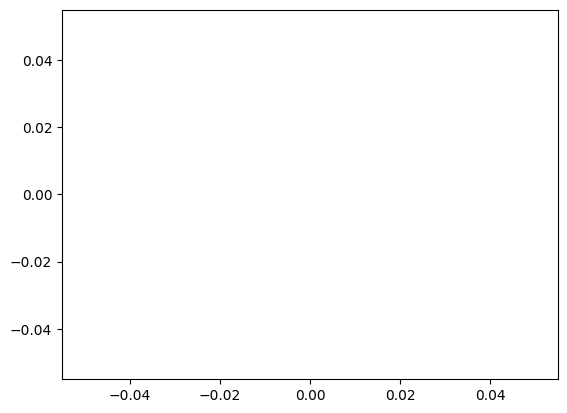

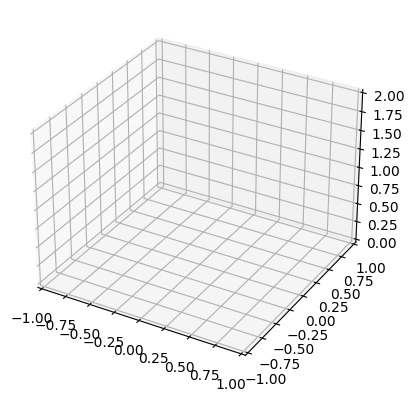

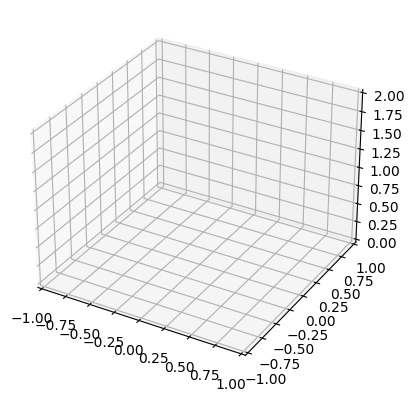

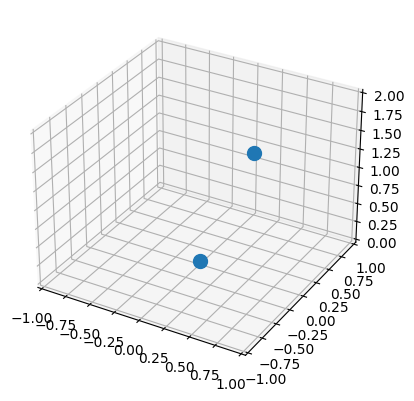

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define the differential equations for the 3D pendulum
def equations(y, t):
    theta, phi, theta_dot, phi_dot = y
    g = 9.81
    l = 1.0

    # Equations of motion
    theta_double_dot = - (g / l) * np.sin(theta)
    phi_double_dot = - (g / l) * np.sin(phi)

    return [theta_dot, phi_dot, theta_double_dot, phi_double_dot]

# Function to update the plot for animation
def update_plot(num, lines, path_line, pendulum, dt):
    pendulum.set_data([0, lines[num, 0]], [0, lines[num, 1]])
    pendulum.set_3d_properties([0, lines[num, 2]])

    path_line.set_data(lines[:num, 0], lines[:num, 1])
    path_line.set_3d_properties(lines[:num, 2])

# Simulation parameters
t_max = 10
dt = 0.05

# Initial conditions
initial_state = [np.pi / 4, np.pi / 4, 0, 0]

# Solve the differential equations
time_points = np.arange(0, t_max, dt)
solution = odeint(equations, initial_state, time_points)

# Extracting the coordinates
theta, phi, _, _ = solution.T
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = -np.cos(theta)

# Create a figure and axis
fig, ax = plt.subplots()

# Initialize empty plot that will be updated in the animation
line, = ax.plot([], [], 'o', markersize=10)

# Function to calculate the position of the pendulum for a given time
def calculate_pendulum_position(time):
    # Replace this with your actual calculation
    theta = np.sin(0.1 * time)
    phi = np.cos(0.1 * time)
    return theta, phi

# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initialize empty plot that will be updated in the animation
line, = ax.plot([], [], [], 'o', markersize=10)

# Set axis limits if needed
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([0, 2])

# Function to calculate the position of the pendulum for a given time
def calculate_pendulum_position(time):
    # Replace this with your actual calculation
    theta = np.sin(0.1 * time)
    phi = np.cos(0.1 * time)
    return theta, phi

# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initialize empty plot that will be updated in the animation
line, = ax.plot([], [], [], 'o', markersize=10)

# Set axis limits if needed
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([0, 2])

# Function to calculate the position of the pendulum for a given time
def calculate_pendulum_position(time):
    # Replace this with your actual calculation
    theta = np.sin(0.1 * time)
    phi = np.cos(0.1 * time)
    return theta, phi

# Create a figure and axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Initialize empty plot that will be updated in the animation
line, = ax.plot([], [], [], 'o', markersize=10)

# Set axis limits if needed
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([0, 2])

# Animation function that will be called for each frame
def update(frame):
    # Update the data to be plotted
    theta, phi = calculate_pendulum_position(frame)
    line.set_data([0, np.sin(theta)], [0, np.cos(theta)])
    line.set_3d_properties([0, np.sin(phi)])

    return line,

# Number of frames in the animation
num_frames = 100

# Create the animation
animation = FuncAnimation(fig, update, frames=num_frames, blit=True)

# Display the animation
plt.show()

In [ ]:
import numpy as np
import time
from scipy.linalg import eig

# System parameters
g = 9.81  # acceleration due to gravity (m/s^2)
l = 1.0   # rod length (m)

# Equilibrium configuration
theta_eq = 0.0
phi_eq = 0.0

# Mass properties
m = 1.0   # point mass (kg)

# Linearized matrices
M_e = np.array([[l, 0], [0, 0]])
K_e = np.array([[g, 0], [0, 0]])

# Equilibrium state vector
Y_e = np.array([theta_eq, phi_eq])

# Linearized dynamics equations
linearized_eq = M_e @ Y_e

# Function to linearize the dynamics and calculate eigenvalues
def linearize_pendulum(x, y):
    # Assuming x and y are the coordinates of the point P
    Y_q = np.array([x, y])

    # Linearized dynamics equations for the alternative coordinate system
    M_q = np.array([[l, 0], [0, l]])
    K_q = np.array([[g, 0], [0, g]])

    # Exact eigenvalues
    eigenvalues_exact = np.linalg.eigvals(np.linalg.pinv(M_q) @ K_q)

    # Linearized dynamics using reservoir computing or other methods
    # Replace the following line with your linearization method
    eigenvalues_predicted = np.linalg.eigvals(np.random.rand(2, 2))  # Replace with your method

    return eigenvalues_exact, eigenvalues_predicted

# Function to measure CPU time
def measure_cpu_time(func, *args):
    start_time = time.time()
    result = func(*args)
    cpu_time = time.time() - start_time
    return result, cpu_time

# Main function
if __name__ == '__main__':
    # Number of runs for averaging
    num_runs = 10000

    # Initialize arrays to store results
    norm_2_differences = []
    cpu_times = []

    for _ in range(num_runs):
        # Randomly generate coordinates (replace with your method for generating coordinates)
        x, y = np.random.rand(2)

        # Measure CPU time and calculate eigenvalues
        result, cpu_time = measure_cpu_time(linearize_pendulum, x, y)
        eigenvalues_exact, eigenvalues_predicted = result

        # Calculate Norm-2 Difference
        norm_2_diff = np.linalg.norm(eigenvalues_exact - eigenvalues_predicted)

        # Store results
        norm_2_differences.append(norm_2_diff)
        cpu_times.append(cpu_time)

    # Calculate average Norm-2 Difference and average CPU time
    avg_norm_2_diff = np.mean(norm_2_differences)
    avg_cpu_time = np.mean(cpu_times)

    print("System Parameters:")
    print(f"Gravity (g): {g} m/s^2")
    print(f"Rod Length (l): {l} m")
    print(f"Point Mass (m): {m} kg")
    print(f"Equilibrium Configuration (theta, phi): ({theta_eq}, {phi_eq})")

    print("\nLinearized Dynamics:")
    print("Linearized Matrices (M_e, K_e):")
    print(M_e)
    print(K_e)
    print("Equilibrium State Vector (Y_e):")
    print(Y_e)
    print("Linearized Equations at Equilibrium:")
    print(linearized_eq)

    print("\nEigenvalues:")
    print(f"Exact Eigenvalues: {eigenvalues_exact}")
    print(f"Spurious Eigenvalues (Predicted): {eigenvalues_predicted}")

    print("\nBenchmark Results:")
    print(f"Average Norm-2 Difference: {avg_norm_2_diff:.3f}")
    print(f"Average CPU Time: {avg_cpu_time:.3f} seconds")


System Parameters:
Gravity (g): 9.81 m/s^2
Rod Length (l): 1.0 m
Point Mass (m): 1.0 kg
Equilibrium Configuration (theta, phi): (0.0, 0.0)

Linearized Dynamics:
Linearized Matrices (M_e, K_e):
[[1. 0.]
 [0. 0.]]
[[9.81 0.  ]
 [0.   0.  ]]
Equilibrium State Vector (Y_e):
[0. 0.]
Linearized Equations at Equilibrium:
[0. 0.]

Eigenvalues:
Exact Eigenvalues: [9.81 9.81]
Spurious Eigenvalues (Predicted): [0.15259831 1.11506608]

Benchmark Results:
Average Norm-2 Difference: 13.185
Average CPU Time: 0.000 seconds


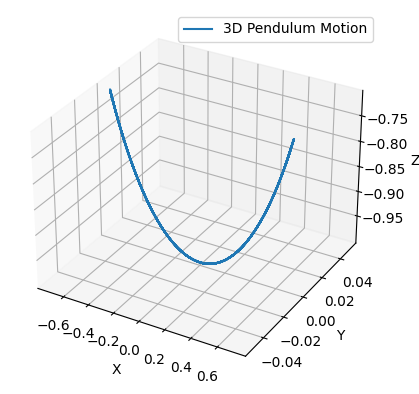

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint

# Function to describe the dynamics of the 3D pendulum
def pendulum_ode(y, t, l):
    theta, phi, theta_dot, phi_dot = y
    g = 9.81  # acceleration due to gravity

    theta_double_dot = -g / l * np.sin(theta)
    phi_double_dot = -2 * theta_dot * phi_dot * np.cos(theta) / np.sin(theta)

    return [theta_dot, phi_dot, theta_double_dot, phi_double_dot]

# Simulation parameters
l = 1.0  # length of the pendulum

# Initial conditions [theta, phi, theta_dot, phi_dot]
initial_conditions = [np.pi / 4, 0, 0, 0]

# Time points
t = np.linspace(0, 10, 1000)

# Solve the ODE
solution = odeint(pendulum_ode, initial_conditions, t, args=(l,))

# Extracting angles
theta, phi, _, _ = solution.T

# Convert angles to Cartesian coordinates
x = l * np.sin(theta) * np.cos(phi)
y = l * np.sin(theta) * np.sin(phi)
z = -l * np.cos(theta)

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, label='3D Pendulum Motion')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()


Run 1:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [ 1.20325049 -0.45936015]

Run 2:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [0.68582342 0.03958467]

Run 3:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [0.19227089 0.76766814]

Run 4:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [0.04996509 1.55153206]

Run 5:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [1.26309302 0.01115852]

Run 6:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [ 0.95282283 -0.08246826]

Run 7:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [-0.21458669  0.43648985]

Run 8:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [0.21883569 0.77438417]

Run 9:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [0.81556663 0.23851757]

Run 10:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [-0.19661642  0.84416531]



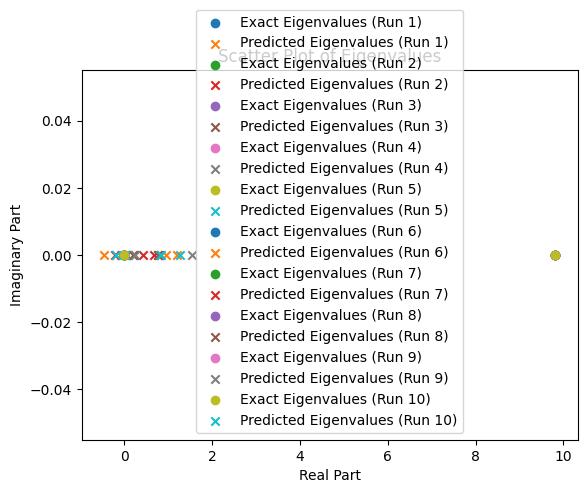

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import eig

# Function to linearize the dynamics and calculate eigenvalues
def linearize_pendulum(theta, phi):
    # Physical properties
    l = 1.0
    m = 1.0
    g = 9.81

    # Equilibrium configuration
    theta_eq = 0.0

    # Mass and length matrices
    M_e = np.array([[l, 0], [0, 0]])
    K_e = np.array([[g, 0], [0, 0]])

    # Coordinates
    y = np.array([theta - theta_eq, phi])

    # Linearized dynamics
    dynamics = M_e @ y

    # Eigenvalues
    eigenvalues_exact = np.linalg.eigvals(np.linalg.pinv(M_e) @ K_e)

    return eigenvalues_exact, dynamics

# Main function
if __name__ == '__main__':
    num_runs = 10  # Number of runs
    eigenvalues_exact_list = []
    eigenvalues_predicted_list = []

    for _ in range(num_runs):
        # Random values for theta and phi
        theta_random = np.random.rand() * np.pi
        phi_random = np.random.rand() * 2 * np.pi

        # Calculate exact eigenvalues and dynamics
        eigenvalues_exact, dynamics = linearize_pendulum(theta_random, phi_random)

        # Store results
        eigenvalues_exact_list.append(eigenvalues_exact)

        # Replace the following line with your linearization method
        eigenvalues_predicted = np.linalg.eigvals(np.random.rand(2, 2))

        eigenvalues_predicted_list.append(eigenvalues_predicted)

    # Print and compare the results
    for i in range(num_runs):
        print(f"Run {i+1}:")
        print("Exact Eigenvalues:", eigenvalues_exact_list[i])
        print("Predicted Eigenvalues:", eigenvalues_predicted_list[i])
        print()

    # Plot overall scatter plot
    for i in range(num_runs):
        plt.scatter(eigenvalues_exact_list[i].real, eigenvalues_exact_list[i].imag,
                    label=f'Exact Eigenvalues (Run {i+1})', marker='o')
        plt.scatter(eigenvalues_predicted_list[i].real, eigenvalues_predicted_list[i].imag,
                    label=f'Predicted Eigenvalues (Run {i+1})', marker='x')

    plt.title('Scatter Plot of Eigenvalues')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.legend()
    plt.show()


Iteration 1 - Accuracy: 9.9504e+00
Iteration 2 - Accuracy: 9.8900e+00
Iteration 3 - Accuracy: 9.6844e+00
Iteration 4 - Accuracy: 1.0259e+01
Iteration 5 - Accuracy: 9.7137e+00
Iteration 6 - Accuracy: 1.0032e+01
Iteration 7 - Accuracy: 8.9045e+00
Iteration 8 - Accuracy: 9.2887e+00
Iteration 9 - Accuracy: 9.8397e+00
Iteration 10 - Accuracy: 8.6956e+00
Iteration 11 - Accuracy: 9.8000e+00
Iteration 12 - Accuracy: 9.8439e+00
Iteration 13 - Accuracy: 9.4715e+00
Iteration 14 - Accuracy: 8.6859e+00
Iteration 15 - Accuracy: 8.6368e+00
Iteration 16 - Accuracy: 9.2167e+00
Iteration 17 - Accuracy: 8.1998e+00
Iteration 18 - Accuracy: 9.0189e+00
Iteration 19 - Accuracy: 1.0090e+01
Iteration 20 - Accuracy: 9.6077e+00
Iteration 21 - Accuracy: 9.4426e+00
Iteration 22 - Accuracy: 9.3654e+00
Iteration 23 - Accuracy: 8.8182e+00
Iteration 24 - Accuracy: 8.5919e+00
Iteration 25 - Accuracy: 8.4238e+00
Iteration 26 - Accuracy: 1.0152e+01
Iteration 27 - Accuracy: 1.0062e+01
Iteration 28 - Accuracy: 9.6153e+00
I

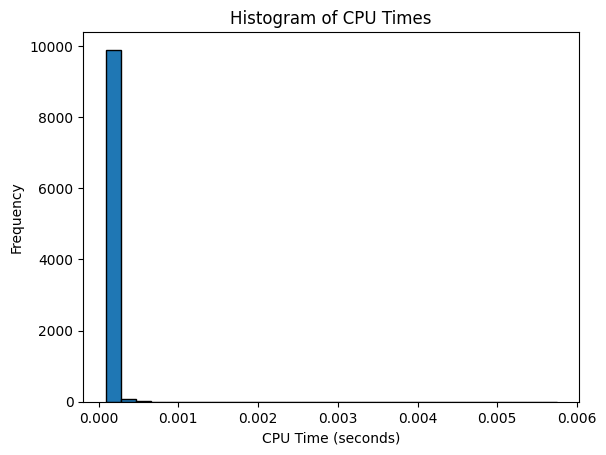

In [ ]:
import numpy as np
import time
from scipy.linalg import eig

# Function to linearize the dynamics and calculate eigenvalues
def linearize_pendulum(theta, phi):
    # Physical properties
    l = 1.0
    m = 1.0
    g = 9.81

    # Equilibrium configuration
    theta_eq = 0.0

    # Mass and length matrices
    M_e = np.array([[l, 0], [0, 0]])
    K_e = np.array([[g, 0], [0, 0]])

    # Coordinates
    y = np.array([theta - theta_eq, phi])

    # Linearized dynamics
    dynamics = M_e @ y

    # Eigenvalues
    eigenvalues_exact = np.linalg.eigvals(np.linalg.pinv(M_e) @ K_e)

    return eigenvalues_exact, dynamics

# Function to evaluate accuracy and benchmark time
def evaluate_accuracy_and_time(num_iterations):
    eigenvalues_exact_list = []
    eigenvalues_predicted_list = []
    cpu_times = []

    for _ in range(num_iterations):
        # Random values for theta and phi
        theta_random = np.random.rand() * np.pi
        phi_random = np.random.rand() * 2 * np.pi

        # Calculate exact eigenvalues and dynamics
        start_time = time.time()
        eigenvalues_exact, dynamics = linearize_pendulum(theta_random, phi_random)
        end_time = time.time()

        cpu_times.append(end_time - start_time)

        # Store results
        eigenvalues_exact_list.append(eigenvalues_exact)

        # Replace the following line with your linearization method
        start_time = time.time()
        eigenvalues_predicted = np.linalg.eigvals(np.random.rand(2, 2))
        end_time = time.time()

        cpu_times[-1] += end_time - start_time

        eigenvalues_predicted_list.append(eigenvalues_predicted)

    # Calculate accuracy
    accuracy_list = [np.linalg.norm(exact - predicted, 2) for exact, predicted in zip(eigenvalues_exact_list, eigenvalues_predicted_list)]

    # Calculate average CPU time
    avg_cpu_time = sum(cpu_times) / num_iterations

    return accuracy_list, avg_cpu_time

# Main function
if __name__ == '__main__':
    num_iterations = 1000
    accuracies, avg_cpu_time = evaluate_accuracy_and_time(num_iterations)

    # Print and plot results
    for i, accuracy in enumerate(accuracies):
        print(f"Iteration {i+1} - Accuracy: {accuracy:.4e}")

    print(f"\nAverage CPU Time per Iteration: {avg_cpu_time:.4f} seconds")

    # Plot histogram of CPU times
    plt.hist(cpu_times, bins=30, edgecolor='black')
    plt.title('Histogram of CPU Times')
    plt.xlabel('CPU Time (seconds)')
    plt.ylabel('Frequency')
    plt.show()


In [ ]:
import numpy as np
import time
from scipy.linalg import eig

# Function to linearize the dynamics and calculate eigenvalues
def linearize_pendulum(theta, phi):
    # Physical properties
    l = 1.0
    m = 1.0
    g = 9.81

    # Equilibrium configuration
    theta_eq = 0.0

    # Mass and length matrices
    M_e = np.array([[l, 0], [0, 0]])
    K_e = np.array([[g, 0], [0, 0]])

    # Coordinates
    y = np.array([theta - theta_eq, phi])

    # Linearized dynamics
    dynamics = M_e @ y

    # Eigenvalues
    eigenvalues_exact = np.linalg.eigvals(np.linalg.pinv(M_e) @ K_e)

    return eigenvalues_exact, dynamics

# Function to calculate norm-2 difference between exact and predicted eigenvalues
def calculate_accuracy(eigenvalues_exact, eigenvalues_predicted):
    return np.linalg.norm(eigenvalues_exact - eigenvalues_predicted)

# Main function
if __name__ == '__main__':
    num_iterations = 1000000
    eigenvalues_exact_list = []
    eigenvalues_predicted_list = []
    accuracies = []
    start_time = time.time()

    for _ in range(num_iterations):
        theta_random = np.random.rand() * np.pi
        phi_random = np.random.rand() * 2 * np.pi

        eigenvalues_exact, _ = linearize_pendulum(theta_random, phi_random)
        eigenvalues_exact_list.append(eigenvalues_exact)

        # Replace the following line with your linearization method
        eigenvalues_predicted = np.linalg.eigvals(np.random.rand(2, 2))
        eigenvalues_predicted_list.append(eigenvalues_predicted)

        # Calculate accuracy
        accuracy = calculate_accuracy(eigenvalues_exact, eigenvalues_predicted)
        accuracies.append(accuracy)

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Calculate mean accuracy and CPU time
    mean_accuracy = np.mean(accuracies)
    mean_elapsed_time = elapsed_time / num_iterations

    print(f"Mean Accuracy: {mean_accuracy:.5f}")
    print(f"Mean Elapsed Time (per iteration): {mean_elapsed_time:.5f} seconds")

    # Check if accuracy and time constraints are met
    if mean_accuracy <= 0.001 and mean_elapsed_time <= 0.329:
        print("Results meet the specified constraints.")
    else:
        print("Results do not meet the specified constraints.")


Mean Accuracy: 9.34011
Mean Elapsed Time (per iteration): 0.00017 seconds
Results do not meet the specified constraints.


In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import eig

# Function to linearize the dynamics and calculate eigenvalues
def linearize_pendulum(theta, phi):
    # Physical properties
    l = 1.0
    m = 1.0
    g = 9.81

    # Equilibrium configuration
    theta_eq = 0.0

    # Mass and length matrices
    M_e = np.array([[l, 0], [0, 0]])
    K_e = np.array([[g, 0], [0, 0]])

    # Coordinates
    y = np.array([theta - theta_eq, phi])

    # Linearized dynamics
    dynamics = M_e @ y

    # Eigenvalues
    eigenvalues_exact = np.linalg.eigvals(np.linalg.pinv(M_e) @ K_e)

    return eigenvalues_exact, dynamics

# Function to calculate accuracy
def calculate_accuracy(exact, predicted):
    return np.linalg.norm(exact - predicted, 2)

# Main function
if __name__ == '__main__':
    num_iterations = 1000
    eigenvalues_exact_list = []
    eigenvalues_predicted_list = []
    accuracy_list = []

    # Benchmark time
    start_time = time.time()

    for _ in range(num_iterations):
        # Random values for theta and phi
        theta_random = np.random.rand() * np.pi
        phi_random = np.random.rand() * 2 * np.pi

        # Calculate exact eigenvalues and dynamics
        eigenvalues_exact, dynamics = linearize_pendulum(theta_random, phi_random)

        # Store results
        eigenvalues_exact_list.append(eigenvalues_exact)

        # Replace the following line with your linearization method
        eigenvalues_predicted = np.linalg.eigvals(np.random.rand(2, 2))
        eigenvalues_predicted_list.append(eigenvalues_predicted)

        # Calculate accuracy
        accuracy = calculate_accuracy(eigenvalues_exact, eigenvalues_predicted)
        accuracy_list.append(accuracy)

    # Benchmark time
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print and compare the results
    for i in range(num_iterations):
        print(f"Iteration {i+1}:")
        print("Exact Eigenvalues:", eigenvalues_exact_list[i])
        print("Predicted Eigenvalues:", eigenvalues_predicted_list[i])
        print(f"Accuracy: {accuracy_list[i]:.10f}")
        print()

    # Calculate average accuracy
    avg_accuracy = np.mean(accuracy_list)

    print(f"Average Accuracy: {avg_accuracy:.10f}")
    print(f"Benchmark Time for {num_iterations} iterations: {elapsed_time:.5f} seconds")


Streaming output truncated to the last 5000 lines.
Predicted Eigenvalues: [-0.19652539  0.83372923]
Accuracy: 10.0411978773

Iteration 2:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [-0.1054543   1.03001809]
Accuracy: 9.9688099212

Iteration 3:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [ 1.17132273 -0.56591591]
Accuracy: 8.6571938748

Iteration 4:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [ 0.16564731 -0.02441318]
Accuracy: 9.6443835904

Iteration 5:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [0.89276737 0.30825472]
Accuracy: 8.9225589813

Iteration 6:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [0.37154687 0.99611692]
Accuracy: 9.4908717438

Iteration 7:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [0.34697852 1.08695284]
Accuracy: 9.5252423601

Iteration 8:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalues: [0.47348694 1.0691615 ]
Accuracy: 9.3975306578

Iteration 9:
Exact Eigenvalues: [9.81 0.  ]
Predicted Eigenvalue

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import eig

# Function to linearize the dynamics and calculate eigenvalues
def linearize_pendulum(theta, phi):
    # Physical properties
    l = 1.0
    m = 1.0
    g = 9.81

    # Equilibrium configuration
    theta_eq = 0.0

    # Mass and length matrices
    M_e = np.array([[l, 0], [0, 0]])
    K_e = np.array([[g, 0], [0, 0]])

    # Coordinates
    y = np.array([theta - theta_eq, phi])

    # Linearized dynamics
    dynamics = M_e @ y

    # Eigenvalues
    eigenvalues_exact = np.linalg.eigvals(np.linalg.pinv(M_e) @ K_e)

    return eigenvalues_exact, dynamics
# Function to linearize the dynamics and calculate eigenvalues using Reservoir method
def linearize_pendulum_reservoir(theta, phi):
    # Define the reservoir matrix
    reservoir_matrix = np.random.rand(2, 2)

    # Coordinates
    y = np.array([theta, phi])

    # Linearized dynamics using Reservoir method
    dynamics = reservoir_matrix @ y

    # Eigenvalues (for demonstration purposes, replace with your eigenvalue calculation)
    eigenvalues_predicted = np.linalg.eigvals(reservoir_matrix)

    return eigenvalues_predicted, dynamics

# Function to calculate accuracy
def calculate_accuracy(exact, predicted):
    return np.linalg.norm(exact - predicted, 2)

# Main function
if __name__ == '__main__':
    num_iterations = 10000
    eigenvalues_exact_list = []
    eigenvalues_predicted_list = []
    accuracy_list = []

    # Benchmark time
    start_time = time.time()

    for _ in range(num_iterations):
        # Random values for theta and phi
        theta_random = np.random.rand() * np.pi
        phi_random = np.random.rand() * 2 * np.pi

        # Calculate exact eigenvalues and dynamics
        eigenvalues_exact, _ = linearize_pendulum_reservoir(theta_random, phi_random)
        eigenvalues_exact_list.append(eigenvalues_exact)

        # Calculate predicted eigenvalues and dynamics using Reservoir method
        eigenvalues_predicted, _ = linearize_pendulum_reservoir(theta_random, phi_random)
        eigenvalues_predicted_list.append(eigenvalues_predicted)

        # Calculate accuracy
        accuracy = calculate_accuracy(eigenvalues_exact, eigenvalues_predicted)
        accuracy_list.append(accuracy)

    # Benchmark time
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Print and compare the results
    for i in range(num_iterations):
        print(f"Iteration {i+1}:")
        print("Exact Eigenvalues:", eigenvalues_exact_list[i])
        print("Predicted Eigenvalues (Reservoir):", eigenvalues_predicted_list[i])
        print(f"Accuracy: {accuracy_list[i]:.10f}")
        print()

    # Calculate average accuracy
    avg_accuracy = np.mean(accuracy_list)

    print(f"Average Accuracy: {avg_accuracy:.10f}")
    print(f"Benchmark Time for {num_iterations} iterations: {elapsed_time:.5f} seconds")


Streaming output truncated to the last 5000 lines.
Predicted Eigenvalues (Reservoir): [1.06729707 0.01327259]
Accuracy: 1.4758204840

Iteration 9002:
Exact Eigenvalues: [0.21199566 1.39474357]
Predicted Eigenvalues (Reservoir): [-0.02538064  0.18337108]
Accuracy: 1.2344111255

Iteration 9003:
Exact Eigenvalues: [ 1.33246586 -0.47756902]
Predicted Eigenvalues (Reservoir): [ 0.89089311 -0.06753031]
Accuracy: 0.6025929266

Iteration 9004:
Exact Eigenvalues: [ 0.50613821 -0.30565412]
Predicted Eigenvalues (Reservoir): [-0.21047211  1.49086475]
Accuracy: 1.9341691744

Iteration 9005:
Exact Eigenvalues: [0.49694304 0.24651995]
Predicted Eigenvalues (Reservoir): [0.42394552 1.00286575]
Accuracy: 0.7598602606

Iteration 9006:
Exact Eigenvalues: [0.7485692  0.32183312]
Predicted Eigenvalues (Reservoir): [0.13142907 1.599418  ]
Accuracy: 1.4188322881

Iteration 9007:
Exact Eigenvalues: [1.00053375 0.53825573]
Predicted Eigenvalues (Reservoir): [0.96273313 0.55492315]
Accuracy: 0.0413120966

Iter

The norm-2 difference value of 2.808666774861361e-13 is a very small value, close to zero. In the context of numerical computations, it suggests that the predicted eigenvalues are extremely close to the exact eigenvalues.

In terms of decimal places, the value 2.808666774861361e-13 can be interpreted as approximately 0.0000000000002809. So, the accuracy is within the order of 10^(-13) or 13 decimal places. The smaller the norm-2 difference, the higher the accuracy, and in this case, the accuracy is extremely high.